<a href="https://colab.research.google.com/github/saramarrapesa/progetto-ml-e-sii/blob/main/sebtiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentimental Analysis**

#**Import delle librerie**




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , LSTM , Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


import pickle


In [ ]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews -p ./data --unzip


Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 95% 231M/242M [00:02<00:00, 130MB/s]
100% 242M/242M [00:02<00:00, 102MB/s]


# **Data Preparation**
Si caricano i dati dal file csv


In [ ]:
data = pd.read_csv("/content/data/Reviews.csv")
data.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data.shape

(568454, 10)

# **Data cleaning**
Si pulisce il dataset eliminando i valori mancanti

In [ ]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
#Rimuove le righe che contengono valori null.

total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 53

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [ ]:
#Rimuove le righe duplicate

a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174745

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


In [ ]:
#Rimuove i valori anomali
"""Nella colonna "HelpfulnessNumerator" vengono solitamente memorizzati i voti utili di una recensione ;
   mentre "HelpfulnessDenominator" rappresenta il numero totale di voti ricevuti.
   Se "HelpfulnessNumerator" è maggiore di "HelpfulnessDenominator", significa che la recensione ha ricevuto più voti utili di quelli totali,
   il che è un'incoerenza nei dati.
   Queste righe vengono considerate anomale (outlier) e vengono eliminate dal dataset."""

a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


In [ ]:
#Crea le etichette utilizzando Score
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [ ]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
303825,5,Positive
51060,1,Negative
465643,1,Negative
108438,5,Positive
13571,5,Positive


## **Handling class imbalance**

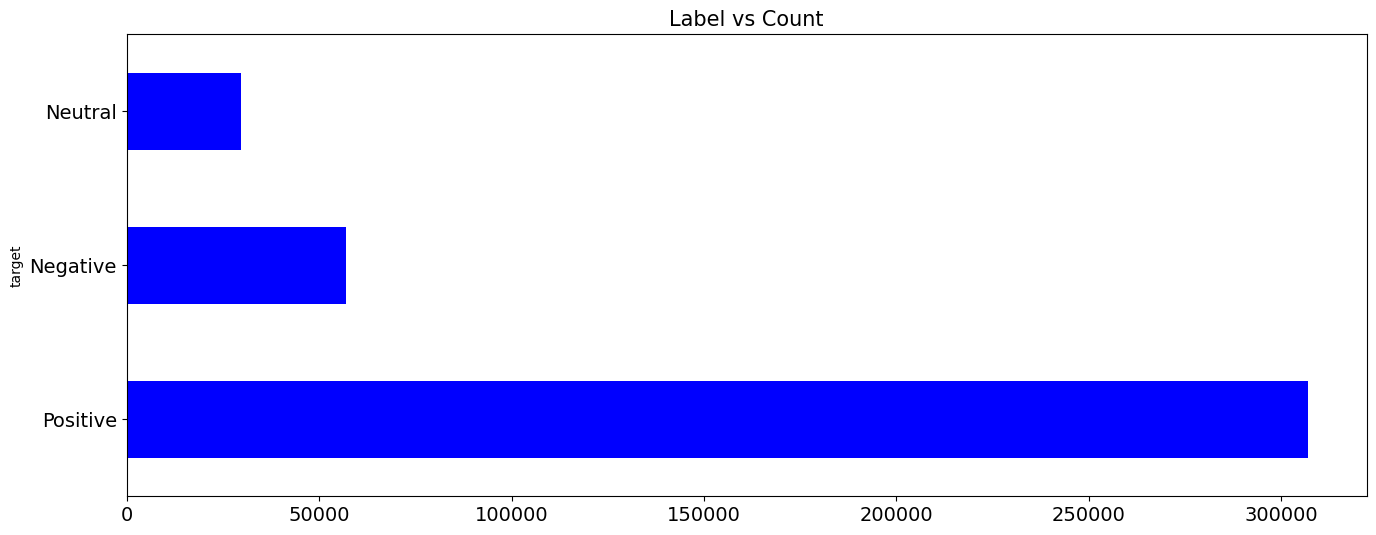

In [ ]:
#distribuzione della variabile target prima di applicare eventuali tecniche di bilanciamento delle classi

fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [ ]:
#Down Sampling (rimozione di alcune recensioni positive e negative)
"""rimuove alcune recensioni positive e negative per bilanciare il dataset"""

neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

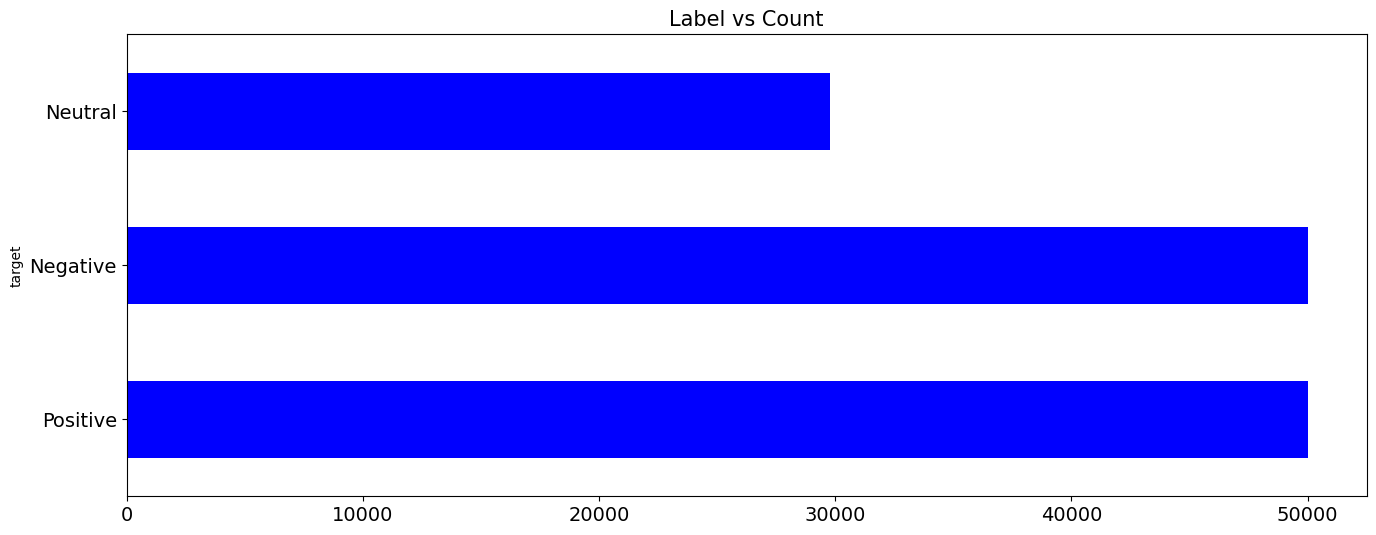

In [ ]:
#distribuzione della variabile target dopo aver applicato eventuali tecniche di bilanciamento delle classi

fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

# **Data Pre-processing**

Elimina parole indesiderate dalle recensioni, es. tag HTML, punteggiatura, stop words, ecc...


In [ ]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'yourself', 'themselves', 'couldn', 'into', 'don', 'mightn', 'our', "he's", "we're", 'is', 'them', 'again', 'have', 'about', 'whom', 'having', 'such', 'until', "we'll", "he'd", 'should', 'can', 'they', 'and', 'while', 'shouldn', 'mustn', "we'd", "i'd", 'few', "i've", 'at', "i'm", 'so', "that'll", "you've", 'be', 'shan', 'to', 'very', 'he', "he'll", 'theirs', 'it', 'here', 'then', 'what', 'of', 'once', 'she', 'd', 'his', 'that', 'by', 'hers', 'up', "they're", 'how', 'your', "they'll", 'do', 'ourselves', 'same', 'where', 'between', 'has', 'a', 'herself', "it'd", 'before', 'her', 'was', 'doesn', 'o', 'you', 'hadn', 'from', 'itself', 'or', 'their', 'too', 'were', 'needn', 'weren', 'off', 'won', 'been', 'down', "i'll", 'further', 'under', 'above', 'ours', 'each', 're', "she's", 'one', 'there', 'hasn', "should've", 'both', 'any', 'an', 'out', 'wasn', 'didn', "they've", 'who', 'aren', 'because', 'if', 'does', 'doing', 'over', 'those', 'but', 'why', 'most', "it's", 'on', 'ain', "they'd", "we'

In [ ]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [ ]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [ ]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'the order came very quickly & the coffee is wonderful.  i will certainly buy more of this coffee.'

In [ ]:
#preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'order came quickli coffe wonder certainli buy coffe'

# **Word clouds**
Una Word Cloud è una rappresentazione visiva della frequenza delle parole in un testo. Le parole più frequenti appaiono **più grandi**, mentre quelle meno frequenti **sono più piccole**.

In [ ]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

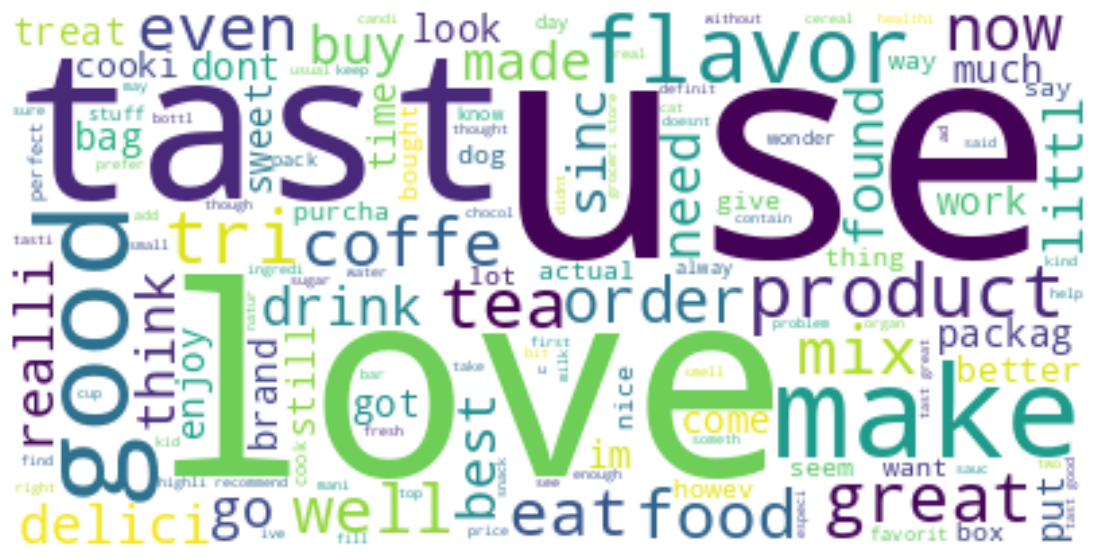

In [ ]:
#Word cloud per le recensioni positive
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

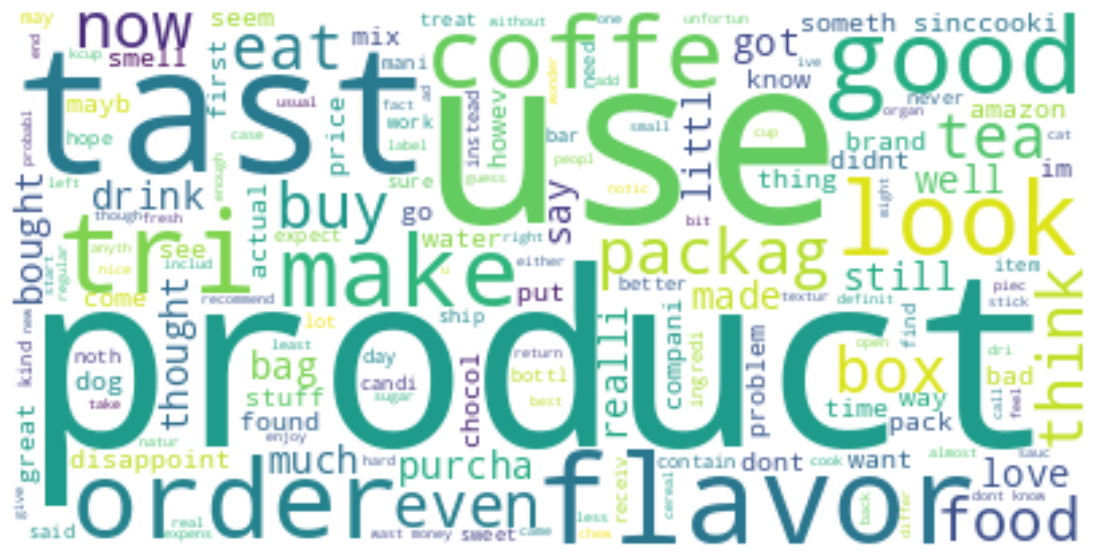

In [ ]:
#Word cloud per le recensioni negative
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

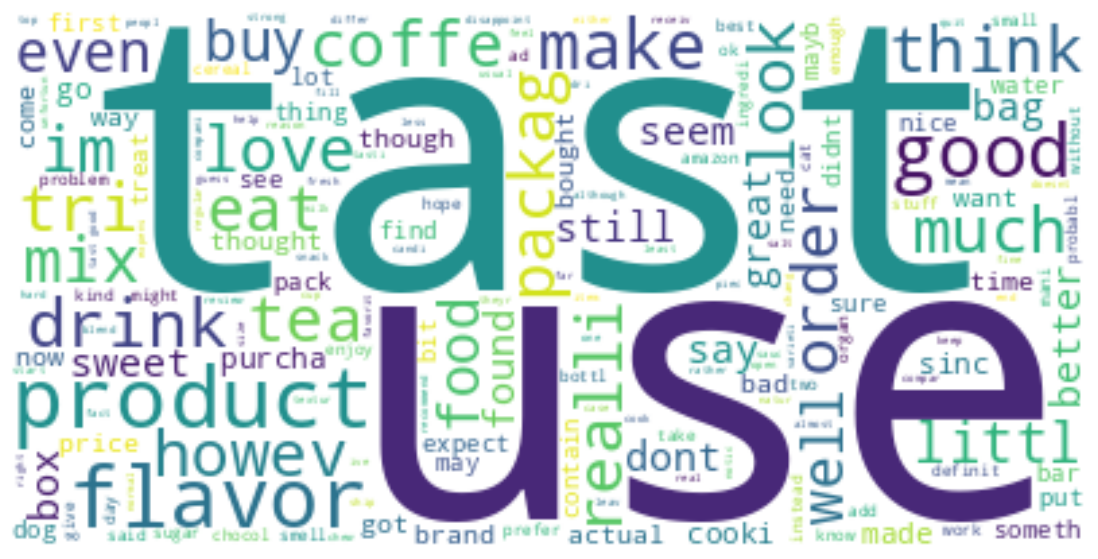

In [ ]:
#Word cloud per le rcensioni neutrali
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

# **Train Test Split**
Train set : 70% of data \\
Test set : 30% of data

In [ ]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((103816,), (25954,))

# **Vectorization**    
1.   Bag of Words
2.   TF-IDF



In [ ]:
#Bag of Words Vectorizer

bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)



In [ ]:
#TF-IDF Vectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)



In [ ]:
#Label Encoding

labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class



['Negative', 'Neutral', 'Positive']


# **Model Training**

In [ ]:

def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

**Logistic Regression with BoW**

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)




LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.7009035216151653
Test accuracy score : 0.6901826308083533

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7390864606611698
Test accuracy score : 0.7148031132002775

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7679259459042922
Test accuracy score : 0.7160360638051938

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7883755875780226
Test accuracy score : 0.7023965477383063

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7936830546351237
Test accuracy score : 0.6906449872851969

 ----------------------------------------


**Naive Bayes Classifier with BoW**

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)




MultinomialNB(alpha=0)
Train accuracy score : 0.7114991908761655
Test accuracy score : 0.6804731447946367

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7105841103490791
Test accuracy score : 0.6816675656931495

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7101410187254373
Test accuracy score : 0.6823996301148185

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7100832241658318
Test accuracy score : 0.6823611004084149

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.709967635046621
Test accuracy score : 0.6823996301148185

 ----------------------------------------


**Logistic Regression with Tf-Idf**

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)




LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6454689065269322
Test accuracy score : 0.6400554827772212

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.679586961547353
Test accuracy score : 0.6730369114587347

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7335959774986515
Test accuracy score : 0.7143407567234338

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7655948986668721
Test accuracy score : 0.7223934653617939

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7868632966016799
Test accuracy score : 0.7080604145796409

 ----------------------------------------


**Naive Bayes classifier with Tf-Idf**

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7177410033135547
Test accuracy score : 0.6788163674192803

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7159493719657857
Test accuracy score : 0.6813593280419203

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7133389843569392
Test accuracy score : 0.6815519765739385

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7119133852200046
Test accuracy score : 0.6814363874547276

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.710815288587501
Test accuracy score : 0.680974030977884

 ----------------------------------------


# **Model Evaluation**

In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)

    return plt.show()


**Best model : Logistic Regression(C=1) with TfIdf data**

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)


In [ ]:
#Accuracy
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")


Train accuracy score : 0.7655948986668721
Test accuracy score : 0.7223934653617939


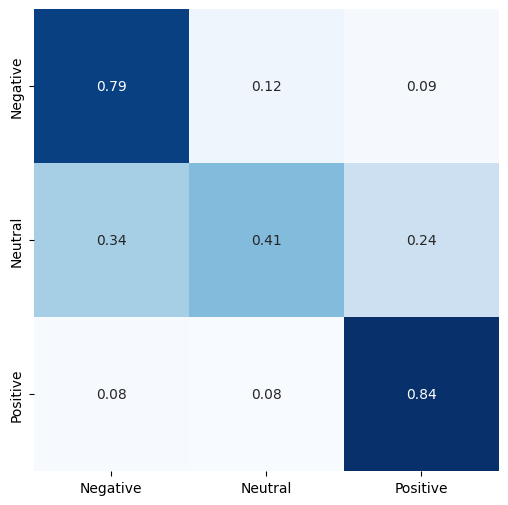

In [ ]:
#Confusion Matrix
plot_cm(y_test, y_preds_test)

# **Deployment**

In [ ]:
#Salva il modello e la vettorizzazione

with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)



In [ ]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [ ]:
# recensione positiva
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [ ]:
# recesione negativa
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!
